# Post-training an LLM using GRPO with TRL

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_

In this notebook, we'll walk you though how to post-training an LLM using Group Relative Policy Optimization (GRPO). GRPO is an RL post-training technique which was part of the training procedure of DeepSeek-R1. This technique seems to be in line of OpenAI-o1 model. In this case, instead of using search-heuristics procedures as in previous ideas, they relied on pure RL for this post-training part.

This training technique is already available as part of the [TRL library](https://huggingface.co/docs/trl/main/en/grpo_trainer#quick-start) and while I write this words, the HF Science team is trying to reproduce the whole DeepSeek-R1 training process in [here](https://github.com/huggingface/open-r1) so go check it out to understand more about the process.

In this case, we focus solely on post-training with GRPO.

Below, you can find a diagram of how this training procedure works.






![Image](https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/grpo_visual.png)

## 1. Install Dependencies

Let’s start by installing the essential libraries we’ll need for fine-tuning! 🚀


In [1]:
!pip install  -U -q transformers trl datasets peft accelerate
# Tested with transformers==4.48.1, trl==0.14.0.dev0, datasets==3.2.0, peft==0.14.0, accelerate==1.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


We need the latest code from TRL, so we download from the main branch.

In [2]:
!pip install git+https://github.com/huggingface/trl.git@main

  Cloning https://github.com/huggingface/trl.git (to revision main) to /tmp/pip-req-build-t9vdy4y0
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-t9vdy4y0
  Resolved https://github.com/huggingface/trl.git to commit 4659ad916fe3e05fd81bf1297db7a6767d2c69bc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for trl: filename=trl-0.14.0.dev0-py3-none-any.whl size=310635 sha256=961b01cb374bf50befab9999f2a4e780c2367ded9cd6e2e39ad839139d790cbe
  Stored in directory: /tmp/pip-ephem-wheel-cache-gfnwpz2j/wheels/86/55/e9/4fb51fd8f4973abd44ac9118a3cf4610b1271263c00f8f85c9
Successfully built trl
  Attempting uninstall: trl
    Found existing installation: trl 0.13.0
    Uninstalling trl-0.13.0:
      Successfully uninstalled trl-0.13.0


In [4]:
!pip install -q flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 33.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Authenticate with your Hugging Face account to save and share your model directly from this notebook 🗝️.

In [5]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load Dataset 📁

These models are specially good in tasks that involve some reasoning to be completed. A good example would be mathematical problems, so we'll use one such dataset for this project.

The dataset is [AI-MO/NuminaMath-TIR](https://huggingface.co/datasets/AI-MO/NuminaMath-TIR), a reasoning dataset consisting of math problemas with their solution and reasoning steps to go from the problem statement to the final solution.

In [1]:
from datasets import load_dataset

dataset_id = 'AI-MO/NuminaMath-TIR'
train_dataset = load_dataset(dataset_id, split='train[:10%]')
#train_dataset, test_dataset = load_dataset(dataset_id, split=['train[:10%]', 'test[:10%]'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
train_dataset

Dataset({
    features: ['problem', 'solution', 'messages'],
    num_rows: 7244
})

In [ ]:
train_dataset[0]

In the case of the DeepSeek-R1 training procedure, they specically used the following system prompt in order to generate a conversational pipeline during the training procedure that includes thinking steps. We'll modify the dataset we'll use in order to make it conversational and to ask the LLM to generate the thinking process.

```
A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think>
<answer> answer here </answer>. User: prompt. Assistant:
```

In [3]:
SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant "
    "first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning "
    "process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., "
    "<think> reasoning process here </think><answer> answer here </answer>"
)

def make_conversation(example):
    return {
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": example["problem"]},
        ],
    }

train_dataset = train_dataset.map(make_conversation)

Let's see how and example looks like:

In [4]:
train_dataset[0]

{'problem': 'What is the coefficient of $x^2y^6$ in the expansion of $\\left(\\frac{3}{5}x-\\frac{y}{2}\\right)^8$?  Express your answer as a common fraction.',
 'solution': "To determine the coefficient of \\(x^2y^6\\) in the expansion of \\(\\left(\\frac{3}{5}x - \\frac{y}{2}\\right)^8\\), we can use the binomial theorem.\n\nThe binomial theorem states:\n\\[\n(a + b)^n = \\sum_{k=0}^{n} \\binom{n}{k} a^{n-k} b^k\n\\]\n\nIn this case, \\(a = \\frac{3}{5}x\\), \\(b = -\\frac{y}{2}\\), and \\(n = 8\\).\n\nWe are interested in the term that contains \\(x^2y^6\\). In the general term of the binomial expansion:\n\\[\n\\binom{8}{k} \\left(\\frac{3}{5}x\\right)^{8-k} \\left(-\\frac{y}{2}\\right)^k\n\\]\n\nTo get \\(x^2\\), we need \\(8 - k = 2\\), thus \\(k = 6\\).\n\nSubstituting \\(k = 6\\) into the expression:\n\\[\n\\binom{8}{6} \\left(\\frac{3}{5}x\\right)^{8-6} \\left(-\\frac{y}{2}\\right)^6 = \\binom{8}{6} \\left(\\frac{3}{5}x\\right)^2 \\left(-\\frac{y}{2}\\right)^6\n\\]\n\nNow, we w

## 3. Post-Training Base Model Using GRPO

In the diagram below, we may see the main differences between the PPO and the GRPO.

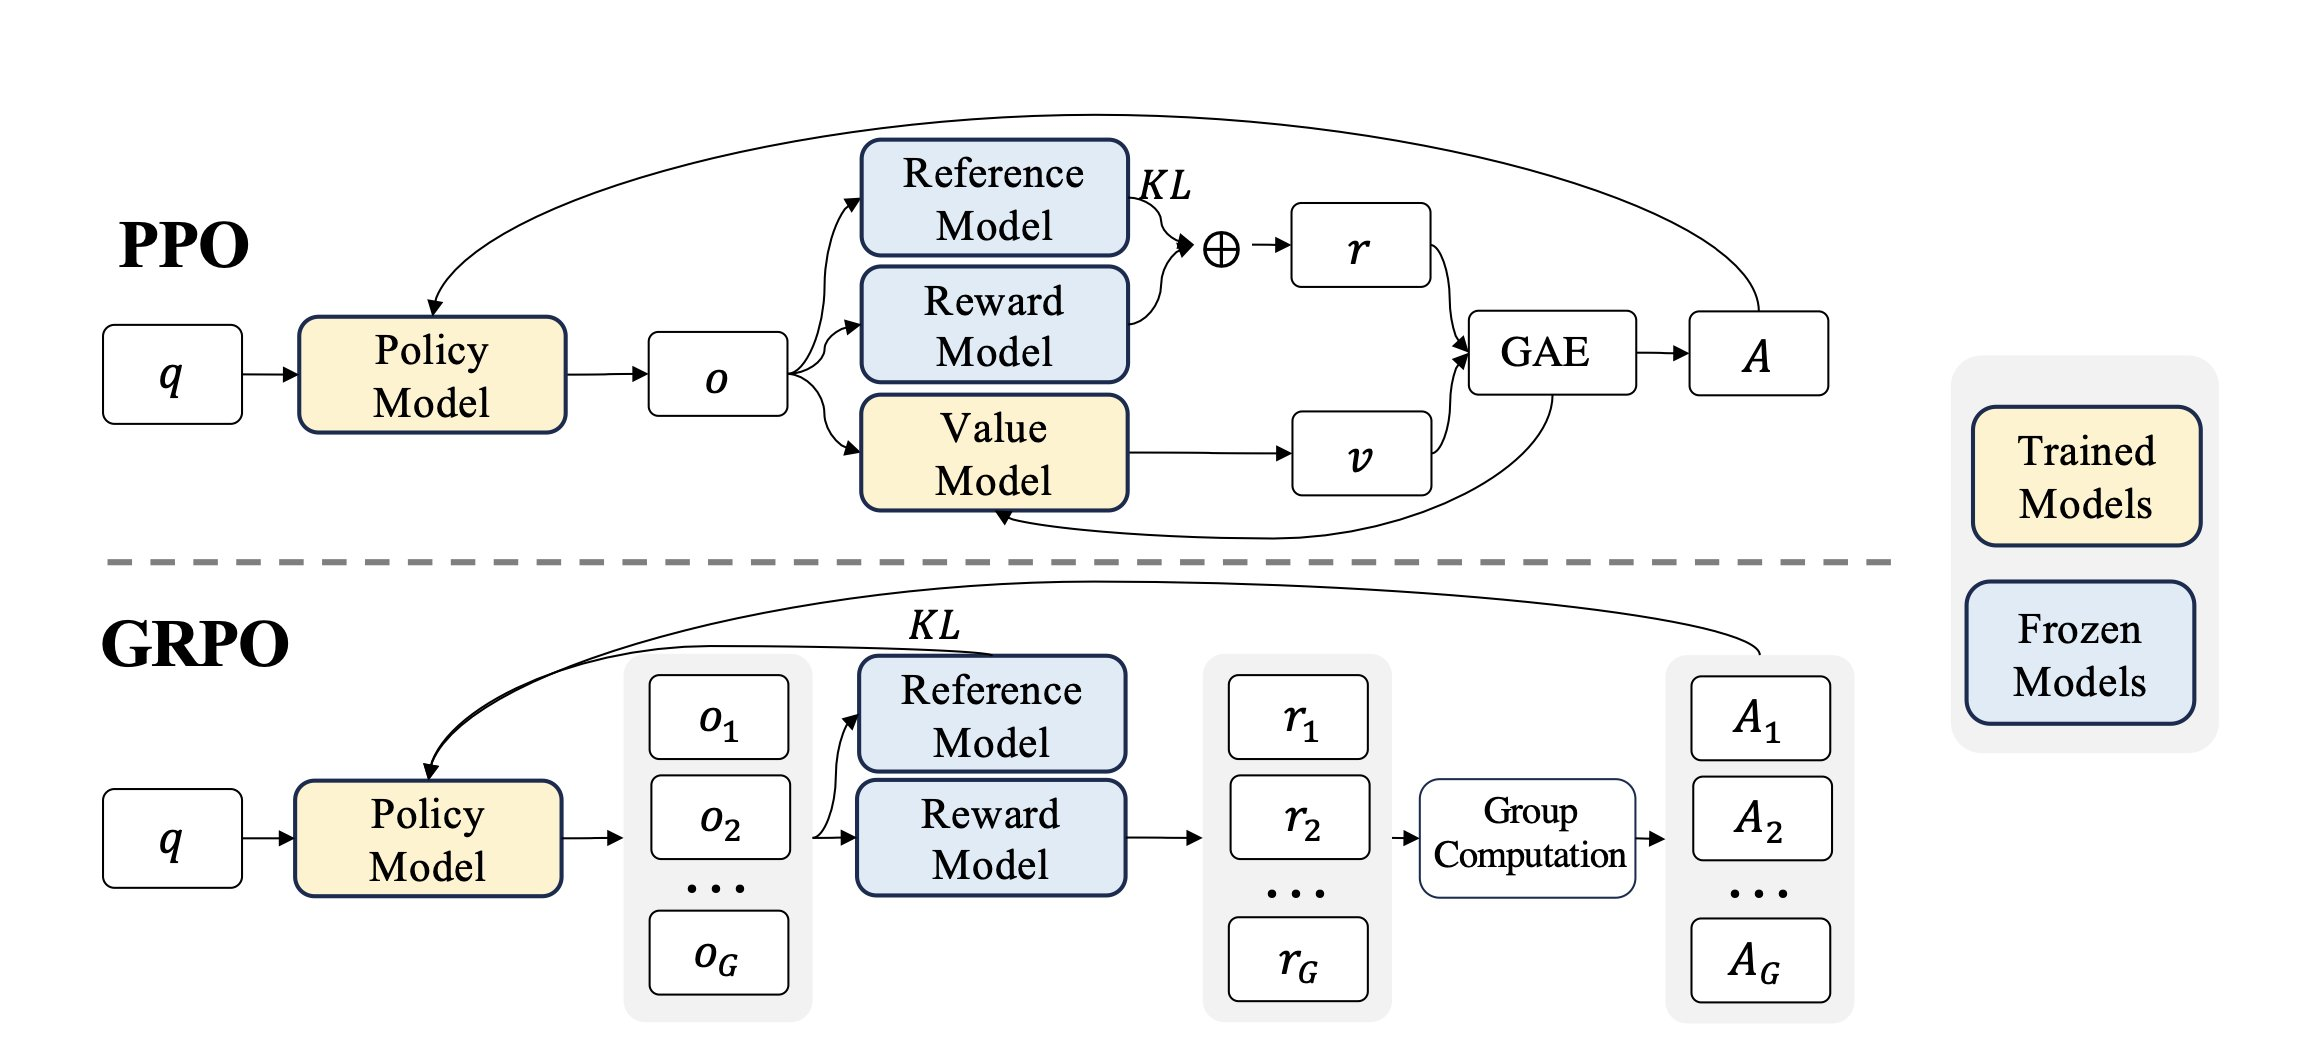

![Image](https://github.com/huggingface/open-r1/blob/main/assets/plan-of-attack.png?raw=true)

### 3.1 Load Baseline Model

Let's first load the baseline model. In this case, we will use an Instruct model with 0.5B parameters to keep thinks small and fit this notebook possibilities. The model used is Qwen/Qwen2-0.5B-Instruct.

In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "Qwen/Qwen2-0.5B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

### 3.2 Configure LoRA

For training the model, we'll apply LoRA.

In [6]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

trainable params: 540,672 || all params: 494,573,440 || trainable%: 0.1093


### 3.3 Load Reward Functions

For the reward part of the system, we can use pretrained models or/and reward functions purely defined in code. In our case, we will use both, a pretrained reward model and in addition, a reward function which will give higher scores to longer completions.

Let's first define the model:

In [7]:
from transformers import AutoModelForSequenceClassification

#reward_model_id = "weqweasdas/RM-Gemma-2B"
reward_model_id = "lewtun/Qwen2-0.5B-Reward"

reward_model = AutoModelForSequenceClassification.from_pretrained(
    reward_model_id,
    num_labels=1,
)

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2-0.5B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


For the reward function, we can directly add a generic python function! We'll use a simple reward function that aims to generate longer completions. In the specific case of the DeepSeek-R1 training, they uses an accuracy reward model evaluating wheter the response is correct and a format reward thar enforces the model to puyt its thinking process between <think> </think> tags.

In [8]:
def reward_func(completions, **kwargs):
    """Reward function that gives higher scores to longer completions."""
    return [float(len(completion)) for completion in completions]

In [11]:
'''
import re
def format_reward(completions, **kwargs):
    """Reward function that checks if the completion has a specific format."""
    #pattern = r"^<think>.*?</think><answer>.*?</answer>$"
    pattern = r"^<think>.*?</think>\s*<answer>.*?</answer>$"
    completion_contents = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, content) for content in completion_contents]
    rewards_list = [1.0 if match else 0.0 for match in matches]
    return [1.0 if match else 0.0 for match in matches]
'''

### 3.4 Configure GRPO Training Parameters

Let's configure the training paramenters for GRPO. In this case, we recommend playing with `max_completion_length`, `num_generations` and `max_prompt_length` params (refer to the image at the beggining for details about each of them).

In [9]:
from trl import GRPOConfig

# Configure training arguments using SFTConfig
training_args = GRPOConfig(
    output_dir="Qwen2-0.5B-GRPO",
    learning_rate=1e-5,
    remove_unused_columns=True, # Removes the "completion" column from the dataset
    gradient_accumulation_steps=16, # 2
    num_train_epochs=3,
    bf16=True,

    # Parameters that control de data preprocessing
    max_completion_length=32, # 64 -> OOM 32, # default: 256
    num_generations=4, # 4 # default: 8
    max_prompt_length=64, # 128--> working with one reward_func, # 256 -> OOM # default: 512

    # Parameters related to reporting and saving
    report_to=["tensorboard"],
    logging_steps=10,
    push_to_hub=True,
    save_strategy="steps",  # Strategy for saving the model
    save_steps=10,
)

### 3.5 Training the Model 🏃

Let's configure the trainer and let's train the model!

In this case, we pass a list of reward functions to the trainer, which are the reward model and reward function previously defined.

In [10]:
from trl import GRPOTrainer

trainer = GRPOTrainer(
    model=model,
    reward_funcs=[reward_model, reward_func],
    args=training_args,
    train_dataset=train_dataset
)

Time to Train the Model! 🎉

In [ ]:
trainer.train()

Step,Training Loss
10,0.000000
20,0.000000
30,0.000100


Let's save the results 💾

In [ ]:
trainer.save_model(training_args.output_dir)
trainer.push_to_hub(dataset_name=dataset_id)

## 4. Check the Model Perfomance

In [32]:
train_dataset['prompt'][0]

[{'content': 'A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>',
  'role': 'system'},
 {'content': 'What is the coefficient of $x^2y^6$ in the expansion of $\\left(\\frac{3}{5}x-\\frac{y}{2}\\right)^8$?  Express your answer as a common fraction.',
  'role': 'user'}]

In [33]:
model_id = "sergiopaniego/Qwen2-0.5B-GRPO-test"
trained_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
)
trained_tokenizer = AutoTokenizer.from_pretrained(model_id)

adapter_model.safetensors:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

In [34]:
prompt = " ".join([entry['content'] for entry in train_dataset['prompt'][0]])
inputs = trained_tokenizer(prompt, return_tensors="pt").to(trained_model.device)

with torch.no_grad():
    outputs = trained_model.generate(**inputs, max_length=2000)

generated_text = trained_tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer> What is the coefficient of $x^2y^6$ in the expansion of $\left(\frac{3}{5}x-\frac{y}{2}\right)^8$?  Express your answer as a common fraction.<think> The coefficient of $x^2y^6$ in the expansion of $(\frac{3}{5}x - \frac{y}{2})^8$ is obtained by multiplying the powers of x and y that occur in the terms of $\left(\frac{3}{5}x\right)$ and $\left(-\frac{1}{2}y\right)$. We can calculate this using the binomial theorem or by expanding the expression directly.

The reasoning process:

To find the coefficient of $x^2y^6$, we need to multiply the powers of x and y that occur in the terms of $\left(\frac{

In [35]:
user_prompt = train_dataset['prompt'][0][1]['content']
start_of_response = generated_text.rfind(user_prompt) + len(user_prompt)

response_text = generated_text[start_of_response:].strip()

print(response_text)

Respuesta generada por el modelo:
 <think> The coefficient of $x^2y^6$ in the expansion of $(\frac{3}{5}x - \frac{y}{2})^8$ is obtained by multiplying the powers of x and y that occur in the terms of $\left(\frac{3}{5}x\right)$ and $\left(-\frac{1}{2}y\right)$. We can calculate this using the binomial theorem or by expanding the expression directly.

The reasoning process:

To find the coefficient of $x^2y^6$, we need to multiply the powers of x and y that occur in the terms of $\left(\frac{3}{5}x\right)$ and $\left(-\frac{1}{2}y\right)$. 

For the term involving $\left(\frac{3}{5}x\right)$, since there's no power of x in the expansion of $\left(\frac{3}{5}x\right)$, its coefficient is simply $\frac{3}{5}$.

For the term involving $\left(-\frac{1}{2}y\right)$, the exponent of y in the term is 6, so its coefficient is $-\frac{1}{2} \cdot 6 = -3$.

Multiplying these two coefficients together gives us the total coefficient of $x^2y^6$: $\frac{3}{5} \cdot -3 = -\frac{9}{5}$.

Therefore, th

In [36]:
import re
def format_reward(completions, **kwargs):
    """Reward function that checks if the completion has a specific format."""
    #pattern = r"^<think>.*?</think><answer>.*?</answer>$"
    pattern = r"^<think>.*?</think>\s*<answer>.*?</answer>$"
    completion_contents = [completion[0]["content"] for completion in completions]
    print(completion_contents)
    for content in completion_contents:
        print(content)
        print(re.match(pattern, content))
    matches = [re.match(pattern, content) for content in completion_contents]
    return [1.0 if match else 0.0 for match in matches]

In [37]:
completions = [[{'content': response_text}]]

format_reward(completions)

["<think> The coefficient of $x^2y^6$ in the expansion of $(\\frac{3}{5}x - \\frac{y}{2})^8$ is obtained by multiplying the powers of x and y that occur in the terms of $\\left(\\frac{3}{5}x\\right)$ and $\\left(-\\frac{1}{2}y\\right)$. We can calculate this using the binomial theorem or by expanding the expression directly.\n\nThe reasoning process:\n\nTo find the coefficient of $x^2y^6$, we need to multiply the powers of x and y that occur in the terms of $\\left(\\frac{3}{5}x\\right)$ and $\\left(-\\frac{1}{2}y\\right)$. \n\nFor the term involving $\\left(\\frac{3}{5}x\\right)$, since there's no power of x in the expansion of $\\left(\\frac{3}{5}x\\right)$, its coefficient is simply $\\frac{3}{5}$.\n\nFor the term involving $\\left(-\\frac{1}{2}y\\right)$, the exponent of y in the term is 6, so its coefficient is $-\\frac{1}{2} \\cdot 6 = -3$.\n\nMultiplying these two coefficients together gives us the total coefficient of $x^2y^6$: $\\frac{3}{5} \\cdot -3 = -\\frac{9}{5}$.\n\nThere

[0.0]

In [92]:
completions = [[{'content': '<thinking> $\\frac{1}{40}$ </thinking> <answer> $\\frac{1}{40}$ </answer>'}]]

format_reward(completions)

['<thinking> $\\frac{1}{40}$ </thinking> <answer> $\\frac{1}{40}$ </answer>']
<thinking> $\frac{1}{40}$ </thinking> <answer> $\frac{1}{40}$ </answer>
None


[0.0]

In [ ]:
trainer.train()

Step,Training Loss
10,0.000100
20,0.000100
30,0.000400
40,0.004000
50,0.002400
60,0.002100
70,0.006500


KeyboardInterrupt: 

In [ ]:
trainer.train()

Step,Training Loss
10,0.000100
20,0.000100
30,0.000100
40,0.000100
50,0.000100
60,0.000100
70,0.000200
80,0.000200
90,0.000200
100,0.000300


TrainOutput(global_step=168, training_loss=0.00026865265369581593, metrics={'train_runtime': 4980.9159, 'train_samples_per_second': 4.363, 'train_steps_per_second': 0.034, 'total_flos': 0.0, 'train_loss': 0.00026865265369581593})

## 5. Continuing the Learning Journey 🧑‍🎓️